<table><tr>
<td><img src="../images/42450c5e679578b596be84e3df088ab1aac8b8ab.jpg" style="width:320px;height:300px"/></td>
<td><img src= "../images/spain_grid.gif" style="width:320px;height:300px"/></td>
<td><img src= "../images/wind_turbine.jpg" style="width:320px;height:300px"/></td> 
</tr></table>

# Predicting Energy Markets in Spain
**Author**: Evan Holder<br>
**Flatiron Data Science**:  Capstone Project<br>
[Github Link]()<br>
[Presentation Link]()<br>

### Table of Contents
___

1. [Background](#Background)<br>
2. [Business Problem](#Business-Problem)<br>
3. [Data Collection](#Data-Collection)<br>
4. [Data Cleaning](#Data-Cleaning)<br>
5. [Data Preparation](#Data-Preparation)<br>
    5.1 [Encode Categorical Features](#Encode-Categorical-Features)<br>
    5.2 [Scaling Continuous Features](#Scaling-Continuous-Features)<br>
    5.3 [Multicolinearity](#Multicolinearity)<br>
6. [Modeling the Actual Price](#Modeling-price_actual)<br>
    6.1 [Lasso Regression](#Lasso-Regression)<br>
    6.2 [XGBoost Regression](#XGBoost-Regression)<br>
    6.3 [Neural Networks](#Neural-Networks)<br>
    6.3.1 [Neural Network 1-to-1](#Neural-Network-1-to-1)<br>
    6.3.2 [Neural Network 24-to-24](#Neural-Network-24-to-24)<br>
    6.3.3 [LSTM Neural Network](#Neural-Network-LSTM)<br>
    6.3.4 [DNN-LSTM Neural Network](#Neural-Network-DNN-LSTM)<br>
7.0 [Modeling the Price Residual](#Modeling-Price_Residual)<br>
8.0 [Impact of Weather Features on Price](#Weather)<br>
### Background <a class="anchor" id="Background"></a>
___
Energy markets are especially volatile. At a high level, energy prices are the result of a supply and demand curve. Demand is mostly impacted by the weather outside (seasonal). Supply can be impacted by a multiude of factors from the availability of generation resources, to politics, to international trade and service outages.  Nominated Electricity Market Operator (NEMOs) are in charge of regulating this supply and demand curve and ensuring a fair market price for both generators and consumers.  It is their job balance the flow of electricity from generating sources with the demand of millions of consumers at every moment, of every day.  Maintaining this supply/demand balance is critical in efficient delivery of electricity.  If electricity generation is too high, generators have to reduce production or be completely disconnect from the grid resulting in wasted resources. If demand is higher than generation, transmission companies are forced to "shed" load resulting brownouts or blackouts for consumers.  Not only is fine-tuning this balance critical in consistent delivery of electricity, but also in keeping electricity prices low. The better NEMOs are able to balance supply and demand, the cheaper it is for generators to produces electricity, transmission companies to deliver it, and the cheaper it is for consumers to purchase it.  
### Business Problem <a class="anchor" id="Business-Problem"></a>
___
With the rise renewable energies, which are significantly impacted by the weather, it has become harder to balance energy supply and demand and keep the grid stable.  Grid instability often results in price uncertainty. By more accurately modeling the price of electricity, we can minimize the effects of a rapidly changing supply and demand balance. Or in other words, the better NEMOs can model the price of electricity, the better they can regulate energy production, limit wasted resources, and more efficiently deliver electricity to the consumer.

**Can we use information about energy generation, transmission, the weather, and the day ahead price to accurately predict the price of electricity tomorrow?**

Some background on the target itself... In reality `price_actual` is an aggregate of about 15 price components.  The largest price components is day-ahead price (`price_day_ahead`).  At 12:00 CES everyday, energy buying and selling agents submit their bids to the day-ahead market.  Here, the day-ahead price is set to satisfy tomorrow's predicted supply and demand curve, by the hour.  In essence, it's the day-ahead price that best reflects tomorrow's predicted supply/demand balance.  From there, supply and demand information is submitted to the TSOs where adjustments may have to be made to accommodate any deviations from the plan. On the day of, the intraday market opens up, where market agents can buy and sell energy at prices adjusted for any deviations the TSO have to make in order to effectively operate the grid over the course of the day. These adjusted prices are reflected in the remaining intraday price components. Together, the day-ahead component combined with the intraday market components make up the final price.
### Data Collection and Cleaning <a class="anchor" id="Data-Collection"></a>
___
The data for the project focuses on the electricity market in Spain. Spain was an obvious choice for this project as there is a multitude of data readily available and well documented. The full cleaning script is located [here](https://github.com/EvanHolder/capstone/blob/main/scripts/EDA_cleaning-components.ipynb).

**Generation, Transmission, Load Data**<br>
Downloaded from the [entso-e Transparency Platform](https://transparency.entsoe.eu/dashboard/show). The entso-e is a network of 39 indepentent Transmission Service Operators (TSOs) across Europe which make up the largest interconnected grid in the world. Cleaning steps included:
* Created datetime index
* Joined tables together
* Imputed the immediate mean for missing data points
* Removed duplicates
* Lagged columns one day

**Weather Data**<br>
Data was scraped from [wunderground.com](wunderground.com).  See the weather scraper [here](https://github.com/EvanHolder/capstone/blob/main/scripts/weather_scraper.py) (Note: Thank you to Bojan stavrikj for your [blogpost](https://bojanstavrikj.github.io/content/page1/wunderground_scraper) and for the helper function `render_page` which I used in my script). Cleaning steps included:
* Created datetime index
* Joined data from 5 cities into a single table
* Dropped rows not at the top of the hour
* Shifted data to account for daylight savings time
* Reformated strings to intergers
* Removed unimportant columns
* Imputed the immediate mean for days with 12 or missing data points
* Interpolated/flagged missing data
* Removed duplicates
* Lagged columns one day

**Price Data**<br>
All pricing data was retrieved from the one and only Spanish TSO [Red Electric Espana](https://www.esios.ree.es/en/market-and-prices). Cleaning steps included:
* Created datetime index
* Dropped duplicates
* Combined tables 

### Import Libraries and Functions  <a class="anchor" id="Import-Libraries-and-Funtions"></a>
___
Data manipulation, cleaning, massaging: pandas, numpy<br>
Modeling: sklearn, keras<br>
Plotting: matplotlib<br>
Custom functions: function.py

In [2]:
# Libraries for data cleaning, massaging:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import datetime as dt


# Modeling Libraries
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from tensorflow.keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

# Save Models
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulate directories 
import os

# Import custom functions
os.chdir('../scripts')
from functions import split_data, sMAPE, SMAPE, compute_metrics, r2,impute_immediate_mean
from functions import resample, plot_metric_range, compile_fit, ensemble_nn
os.chdir('../notebooks')

### Import Data <a class="anchor" id="Import-Data"></a>
___

In [3]:
# Read in data
df_lag = pd.read_csv('../data/clean/df_clean_lag.csv', index_col=0, parse_dates=True)

### Data Preparation <a class="anchor" id="Data-Preparation"></a>
___
In this project, we'll focus on three main algorithms types: Lasso Regression, XGBoost, and Neural Networks.  We'll need to prepare the data in slightly different ways for each of the these model types. Much of the preprocessing was already taken care of as part of the steps list above in [Data Cleaning](#Data-Cleaning). The remaining steps are model specific, and so are prepared below:<br><br>
**Lasso Regression**: Encode the categorical features, remove mulitcolinearities<br>
**Neural Networks**: Encode the categorical features

### Encode Catergorical Features <a class="anchor" id="Encode-Categorical-Features"></a>

In [4]:
# Get Categorical columns
categorical = df_lag.select_dtypes(include='object')

# Instationate wind_dir_coder LabelEncoder, fit
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df_lag['wind_madrid_lag'])

# Transform wind_direction cols
for col in categorical.filter(regex='wind').columns:
    df_lag[col] = wind_dir_coder.transform(df_lag[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate condition_coder LabelEncoder, fit on stacked conditions
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)

# Transform condition cols
for col in categorical.filter(regex='condition').columns:
    df_lag[col] = condition_coder.transform(df_lag[col])

In [5]:
# Get price components not to be used in modeling
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')


### Scaling Continuous Features <a class="anchor" id="Scaling-Continuous-Features"></a>
For neural networks, continuous features do not necessarily need to be scaled. However according to this [article](https://www.sciencedirect.com/science/article/pii/S030626191830196X#s0235), which uses neural networks to predict electrical prices, scaling your continuous features generally increases accuracy of deep learning models on the validation set.  We'll give it a go here and scale the the continuos features between [-1,1] for the neural networks we'll train later.

In [6]:
# Copy the dataframe for neural networks
df_nn = df_lag.drop(columns=price_cols).copy()
continuous = df_nn.select_dtypes(exclude='object').filter(regex='^(?!.*price).*').columns

# Get rid of negatives
time = dt.datetime(2021,3,24,22)
df_nn.loc[time, 'dew_point_bilbao_lag'] = impute_immediate_mean(df_nn['dew_point_bilbao_lag'], time)

# Rescale data [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_nn[continuous] = scaler.fit_transform(df_nn[continuous])

### Multicolinearity <a class="anchor" id="Multicolinearity"></a>
One of the assumptions for regression is that featu
res do not contain multicolinearities.  In this section, we'll investigate the predictors and eliminate any multicolinearities in preparation for a lasso regression. We'll need to find out which features are correlated with each other, and remove some of them to rid our dataset of multicolinearities. The steps are outlined below:
1. Copy the dataframe, we'll modify this dataset for use in lasso regression
2. Get the correlations between predictors, sort them in descending order
3. Get the correlations between each individual predictor and the response variable
4. Get the features which have a correlation greater than 0.8, add the feature which correlates less with price_actual to the drop list
5. Drop the features in the drop list

In [7]:
# Copy dataset for lasso regression specific preparation
df_lr = df_lag.drop(columns=price_cols).copy()

# Create correlation matrix predictors to predictors
corr = df_lr.drop(columns='price_actual').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr.rename(columns={0:'cor'}, inplace=True)  # Rename correlation column
corr = corr.loc[corr['cor']!=1]  # remove correlations between same variables
corr.drop_duplicates(subset='cor', inplace=True) # remove duplicate correlations
corr.reset_index(drop=True, inplace=True) # Reset the index
corr.cor =corr.cor.apply(lambda x: round(x,3))  # Round

# Create correlation matrix predictors to response variable
corr_price = df_lr.corr()['price_actual'].reset_index().sort_values('price_actual', ascending=False)
corr_price = corr_price.loc[corr_price['price_actual']!=1] # remove correlations between same variables
corr_price.reset_index(drop=True, inplace=True)  # Reset the index


drop = []

# For each feature pair where corr > 0.8, add feature with lower corr to price_actual to drop list
for row in range(len(corr.loc[corr.cor>.8])):
    var1 = corr.loc[row,'level_0'] # Get var1 name
    var2 = corr.loc[row,'level_1'] # Get var2 name
    var1_corr = float(corr_price.loc[corr_price['index'] == var1, 'price_actual'])  # Get var1 corr
    var2_corr = float(corr_price.loc[corr_price['index'] == var2, 'price_actual'])  # Get var2 corr
    
    # Add the lower correlation to the drop list
    if var1_corr > var2_corr:
        drop.append(var2)
    else:
        drop.append(var1)
        
# Drop the features in the drop listi
df_lr.drop(columns=drop, inplace=True)

In [8]:
df_xg = df_lag.drop(columns=price_cols)

### Modeling `price_actual` <a class="anchor" id="Modeling-price_actual"></a>
___
**Performance Metrics**
Our frame of reference for modeling the tomorrow's actual price will be the day-ahead price which is established at 12 CET (the day before), as this is the best guess for tomorrow's price.  Below, I'll make a table to hold our model results.  The table will include:

**R-squared**: Chosen because this is a regression task.  R-squared represents the proportion of variance explained by the dependent variable.

**Symmetrical Mean Absolute Percentage Error (SMAPE)**: Chosen because the starting point for r-squared is very very high (0.97).  The advantage to using SMAPE is it symmetry. MAPE has a lower bound of 100% over the actual but no upper bound.  In contrast, SMAPE is bound between 200% below and 200% above the actual. Again, because there is only modest room for improvement in r-squared, and so the primary measure of accuracy here will be SMAPE.

**<u>NOTE</u>**: It should be documented that when I began this project, I had downloaded a version of this dataset from [Kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather).  When I imported the data and indexed it with datetime objects, I found that the first 12 days of each month often do not track well with the actual price.  At one point I decided to grab more data from more recent years and noticed the creator of the Kaggle dataset seemed have made an error. The data should have been read in from its original form in the [Transparency Platform](https://transparency.entsoe.eu/dashboard/show) in as DD-MM-YYYY-HH format but instead appears to have been misread in as MM-DD-YYYY-HH format. After fixing this mistake in the original Kaggle dataset, the r-squared increases from 0.54 to 0.96.

In [8]:
# Benchmark results
NEMO_train = df_lag.loc[:'2019', 'price_day_ahead']
NEMO_val = df_lag.loc['2020', 'price_day_ahead']

actual_train = df_lag.loc[:'2019', 'price_actual']
actual_val = df_lag.loc['2020', 'price_actual']

# Create dataframe
results_actual = pd.DataFrame(index=['Parameters','SMAPE_train', 'SMAPE_val', 'r2_train', 'r2_val'])

# Add the baseline NEMO predictions
results_actual['NEMO'] = ['None',
                                    round(sMAPE(actual_train, NEMO_train), 3),
                                    round(sMAPE(actual_val, NEMO_val), 3),
                                    round(r2(actual_train, NEMO_train), 3), 
                                    round(r2(actual_val, NEMO_val),3)]
results_actual

,NEMO
Parameters,None
SMAPE_train,16.03
SMAPE_val,16.922
r2_train,0.954
r2_val,0.971


In [9]:
X_train, y_train, X_val, y_val = split_data(df_lr, 2020, 'price_actual')
with open('../models/Lasso.pickle', 'rb') as file:
    lasso = pickle.load(file)
with open('../models/Lasso1.pickle', 'rb') as file:
    lasso1 = pickle.load(file)
with open('../models/Lasso2.pickle', 'rb') as file:
    lasso2 = pickle.load(file)
with open('../models/XGBoost.pickle', 'rb') as file:
    xg = pickle.load(file)
with open('../models/XGBoost1.pickle', 'rb') as file:
    xg1 = pickle.load(file)
with open('../models/XGBoost2.pickle', 'rb') as file:
    xg2 = pickle.load(file)
with open('../models/XGBoost3.pickle', 'rb') as file:
    xg3 = pickle.load(file)
nn1 = keras.models.load_model('../models/nn1', custom_objects={'SMAPE':SMAPE})
nn2 = keras.models.load_model('../models/nn2', custom_objects={'SMAPE':SMAPE})
nn3 = keras.models.load_model('../models/nn3', custom_objects={'SMAPE':SMAPE})
nn4 = keras.models.load_model('../models/nn4', custom_objects={'SMAPE':SMAPE})
nn5 = keras.models.load_model('../models/nn5', custom_objects={'SMAPE':SMAPE})
nn6 = keras.models.load_model('../models/nn6', custom_objects={'SMAPE':SMAPE})
    

results_actual['Lasso'] = compute_metrics(lasso, 'Vanilla', (X_train, y_train), (X_val, y_val))
train_cols = ['humidities_bilbao_lag', 'oil_lag', 'renewable_lag', 'waste_lag', 'price_day_ahead']
results_actual['Lasso1'] = compute_metrics(lasso1, {'num_features':5}, (X_train[train_cols], y_train), (X_val[train_cols], y_val))
X_train1, X_val1 = X_train.drop(columns='price_day_ahead'), X_val.drop(columns='price_day_ahead')
results_actual['Lasso2'] = compute_metrics(lasso2, {'price_day_ahead':False}, (X_train1, y_train), (X_val1, y_val))
X_train, y_train, X_val, y_val = split_data(df_xg, 2020, 'price_actual')
results_actual['XGBoost'] = compute_metrics(xg, 'Vanilla',(X_train, y_train), (X_val, y_val))
results_actual['XGBoost1'] = compute_metrics(xg1, {'max_depth':2},(X_train, y_train), (X_val, y_val))
X_train1, X_val1 = X_train.drop(columns='price_day_ahead'), X_val.drop(columns='price_day_ahead')
results_actual['XGBoost2'] = compute_metrics(xg2, {'max_depth':2,
                                                   'price_day_ahead':False},(X_train1, y_train), (X_val1, y_val))
results_actual['XGBoost3'] = compute_metrics(xg3,
                                             {'max_depth':16, 'price_day_ahead':False},
                                             (X_train1, y_train), 
                                             (X_val1, y_val))


X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')
results_actual['nn1'] = compute_metrics(nn1, '1-to-1', (X_train,y_train), (X_val, y_val))

X_train, y_train, X_val, y_val = split_data(df_nn.drop(columns='price_day_ahead'), 2020, 'price_actual')
results_actual['nn2'] = compute_metrics(nn2, '1-to-1, price_day_ahead:False', (X_train,y_train), (X_val, y_val))

X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')
X_train, y_train = resample((X_train, y_train), 24, 24, 24)
X_val, y_val = resample((X_val,y_val), 24, 24, 24)
results_actual['nn3'] = compute_metrics(nn3, '24-to-24', (X_train,y_train), (X_val, y_val))


X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')
X_train, y_train = resample((X_train, y_train), 24*7, 24, 24)
X_val, y_val = resample((X_val,y_val), 24*7, 24, 24)
results_actual['nn4'] = compute_metrics(nn4, 'LSTM, 7-day input', (X_train,y_train), (X_val,y_val))
results_actual['nn5'] = compute_metrics(nn5, 'LSTM, 7-day input', (X_train,y_train), (X_val,y_val))

In [10]:
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')
X_train_lstm = X_train.filter(regex='lag')
X_train_dnn = X_train.drop(columns=X_train_lstm.columns)
X_val_lstm = X_val.filter(regex='lag')
X_val_dnn = X_val.drop(columns=X_val_lstm.columns)
X_train_dnn, y_train_dnn = resample((X_train_dnn, y_train), 24, 24, 24)
X_val_dnn, y_val_dnn = resample((X_val_dnn, y_val), 24, 24, 24)
X_train_lstm, y_train_lstm = resample((X_train_lstm, y_train), 24, 24, 24)
X_val_lstm, y_val_lstm = resample((X_val_lstm, y_val), 24, 24, 24)
results_actual['nn6'] = compute_metrics(nn6,
                                        'dnn-lstm, 1-day input',
                                        ([X_train_dnn, X_train_lstm],y_train),
                                        ([X_val_dnn, X_val_lstm],y_val))

In [11]:
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},4.134,8.354,0.954,0.971
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,2.468,3.946,0.983,0.979
nn2,"1-to-1, price_day_ahead:False",6.849,23.042,0.907,0.428


### Lasso Regression <a class="anchor" id="Lasso-Regression"></a>
I'll start with a simple Lasso Regression.  Lasso Regression is really just a a linear regression that introduces a penalty infront of each coefficient in the model. Lasso is well-suited for datasets with high multicolinearities since it automatically selects for one of the features in a colinear pair. As part of the [preprocessing] for this model, I also remove features with high colinearity (>0.8). In fitting the below, I'll take the following steps:

* Split the data into training (2015-2019) and validation (2020)
* Fit a Vanilla lasso regression model with max_iter=10000 to make sure that the model converges.
* Compute the output and add it to the results table.

In [11]:
# Split the data
X_train, y_train, X_val, y_val = split_data(df_lr, 2020, 'price_actual')

# Instatiate and fit model on 
lasso = Lasso(max_iter=10000, random_state=17)
lasso.fit(X_train, y_train)

# Add results of vanilla lasso to dataframe
results_actual['Lasso'] = compute_metrics(lasso, 'Vanilla', (X_train, y_train), (X_val, y_val))

# Save model
with open('../models/Lasso.pickle', 'wb') as f:
    pickle.dump(lasso, f)

results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973


In [33]:
with open('../models/lasso_vanilla.pickle', 'rb') as file:
    lasso_test = pickle.load(file)

The vanilla model performed extremely well.  That's great, but it also isn't suprising given that we used the `price_day_ahead` as a predictor which has an r-squared value of 0.971 on the validation set.  The model outperformed the NEMO predictions in SMAPE and even increased r-squared by a small margin. Increased r-squared must mean that some of the other features were important in our prediction of `price_actual`.  I plotted the coefficients for this vanilla model on the below barchart.

<img src="../images/lasso_feature_importance.png" style="width:700px;height:272px"/>

As expected, `price_day_ahead` dominates this model, though renewable generation and waste generation have an impact, negatively affecting the price (renewable and waste increase, results in price decrease).  Other than that, the other features have very little influence on the final price.  

**Recursive Feature Elimination**<br>
As part of the [Lasso](https://github.com/EvanHolder/capstone/blob/main/notebooks/LassoRegression.ipynb) notebook, I ran a recursive feature elimination to see how the model performs with varying amounts of features in the model.  I started with a single feature (`price_day_ahead`), trained a model, and computed its metrics. Then I iteratively added in the next most important feature, trained the new model, and computed its metrics.  This process was repeated until all features were added back into the training set and the metrics were plotted as below.

![RFE_LassoRegression](../images/RFE_LassoRegression.png)

As shown above, when trained on top five features, the model minimizes r-squared.  Below, I'll train the model on these top five features (`price_day_ahead`, `renewable_lag`,`waste_lag`,`oil_lag`,`humidities_seville_lag`).

In [12]:
# Important Features
train_cols = ['humidities_bilbao_lag', 'oil_lag', 'renewable_lag', 'waste_lag', 'price_day_ahead']

# Instatiate and fit model on 
lasso1 = Lasso(max_iter=10000,random_state=17)
lasso1.fit(X_train[train_cols], y_train)

# Add results of vanilla lasso to dataframe
results_actual['Lasso1'] = compute_metrics(lasso1, {'num_features':5}, (X_train[train_cols], y_train), (X_val[train_cols], y_val))

# Save model
with open('../models/Lasso1.pickle', 'wb') as f:
    pickle.dump(lasso1, f)
    
# Preview
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969


Since Lasso1 includes only five predictors, it's not surprising that the model performance (SMAPE & r-squared) decreased from the vanilla model.  Performance decreased only marginally though.  Next, let's see just how well we can do without using `price_day_ahead`.

In [14]:
# Drop 'price_day_ahead'
X_train1, X_val1 = X_train.drop(columns='price_day_ahead'), X_val.drop(columns='price_day_ahead')

# Instatiate and fit model on 
lasso2 = Lasso(max_iter=10000, random_state=17)
lasso2.fit(X_train1, y_train)

# Add results of vanilla lasso to dataframe
results_actual['Lasso2'] = compute_metrics(lasso2, {'price_day_ahead':False}, (X_train1, y_train), (X_val1, y_val))

# Save Model
with open('../models/Lasso2.pickle', 'wb') as f:
    pickle.dump(lasso2, f)

# Preview
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557


Lasso2 performed approximately half as well as the other two Lasso models (SMAPE, r-squared).  The difference in performance between these models indicates that we really need `price_day_ahead` to match the NEMO's performance.

### XGBoost Regression <a class="anchor" id="XGBoost-Regression"></a>
XGBoost is the next choice in Machine Learning algorithms because of it's ability to learn non-linear decision boundaries.  So while we were unsuccessful in modeling without `price_day_ahead` with Lasso Regression, we'll give it another shot here with XGBoost.  XGBoost was chosen over Random Forest and other gradient boosted ensembles because it trains the fastest and generally performs better. The other great thing about XGBoost is it requires very little prepocessing. In fitting the below, I'll take the following steps:

* Split the data into training (2015-2019) and validation (2020)
* Fit a Vanilla XGBoostRegressor with random_state set to 17
* Compute the output and add it to the results table.

In [15]:
# Split the data
X_train, y_train, X_val, y_val = split_data(df_xg, 2020, 'price_actual')

# Instantiate and fit XGBRegressor
xg = XGBRegressor(random_state=17)
xg.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGBoost'] = compute_metrics(xg, 'Vanilla',(X_train, y_train), (X_val, y_val))

# Save Model
with open('../models/XGBoost.pickle', 'wb') as f:
    pickle.dump(xg, f)

# Preview
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968


The vanilla model did beat the NEMO performance (SMAPE , r-squared) but surprisingly did not outperform the vanilla Lasso model. The model does not appear too overfit on r2_val, but partly on SMAPE_val.  As part of the [XGBoost notebook](https://github.com/EvanHolder/capstone/blob/main/notebooks/XGBoost.ipynb) I tried to reduce this overfitting on by iteratively training XGBoost models and tuning the below parameters.

max_depth....................... [1,2,4,6,8,10,14,16,20],<br>
gamma............................. [n/10 for n in range(11)]<br>
min_child_weight.............. [1,2,4,8,16,32],<br>
subsample........................ [n/10 for n in range(0, 12, 2)],<br>
colsample_bytree............. [n/10 for n in range(0, 12, 2)],<br>
reg_alpha......................... [.001, .01, .1, .5, 1],<br>
reg_lambda...................... [.001, .01, .1, .5, 1]

Adjusting all of these parameters in their respective ranges, there really wasn't much improvement in either of the metrics sMAPE or r2. The one exception may be `max_depth` which did see minor improvement in SMAPE when reduced set to 2.

Below, I'll run another model ith `max_depth` set to 2 and add it to the results table.

Tuning these parameters did not change the metrics in a substantial way.  `Max_depth`, the most influential, made only a marginal difference SMAPE.  

In [16]:
# Split the data
X_train, y_train, X_val, y_val = split_data(df_xg, 2020, 'price_actual')

# Instantiate and fit XGBRegressor
xg1 = XGBRegressor(random_state=17, max_depth=2)
xg1.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGBoost1'] = compute_metrics(xg1, {'max_depth':2},(X_train, y_train), (X_val, y_val))

# Save Model
with open('../models/XGBoost1.pickle', 'wb') as f:
    pickle.dump(xg1, f)

# Preview
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97


XGBoost1 does have a reduced SMAPE_val and increased r2_val, but does not outperform Lasso.  Let's next look at the feature importances from XGBoost1. I suspect that like Lasso, and given that a max tree depth of two is all we need for good performance, that `price_day_ahead` again dominates.

In [17]:
imp = pd.DataFrame({'importance':xg1.feature_importances_},
                   index=X_train.columns).sort_values(by='importance', ascending=False)
imp.head(10)

,importance
price_day_ahead,0.735356
biomass_lag,0.046353
renewable_lag,0.037915
load_forecast,0.035208
coal_lag,0.034028
waste_lag,0.020222
transmission_fs_lag,0.008342
dew_point_seville_lag,0.007706
solar_lag,0.006477
reservoir_lag,0.006204


As expected, the `price_day_ahead` has dominated.  Let's remove it and see how we do.

In [18]:
# Drop price_day_ahead
X_train1, X_val1 = X_train.drop(columns='price_day_ahead'), X_val.drop(columns='price_day_ahead')


# Instantiate and fit XGBRegressor
xg2 = XGBRegressor(random_state=17)
xg2.fit(X_train1, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGBoost2'] = compute_metrics(xg2, {'max_depth':2,
                                                   'price_day_ahead':False},(X_train1, y_train), (X_val1, y_val))
# Save Model
with open('../models/XGBoost2.pickle', 'wb') as f:
    pickle.dump(xg2, f)

# Preview
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427


Again without our most important feature, the model performance has essentially halved (SMAPE and r2).  I further tuned XGBoost trained without `price_day_ahead` but the peformance did not improve substantially. Increasing tree depth was the only parameter that seemed to increase performance.  Below is another list of the tuned parameters, see the [notebook](https://github.com/EvanHolder/capstone/blob/main/notebooks/XGBoost.ipynb) for the plots displaying each model, and how it performed with the below list of tuned parameters.

max_depth....................... [1,2,4,6,8,10,14,16,20],<br>
gamma............................. [n/10 for n in range(11)]<br>
min_child_weight.............. [1,2,4,8,16,32],<br>
subsample........................ [n/10 for n in range(0, 12, 2)],<br>
colsample_bytree............. [n/10 for n in range(0, 12, 2)],<br>
reg_alpha......................... [.001, .01, .1, .5, 1],<br>
reg_lambda...................... [.001, .01, .1, .5, 1]

Lastly, I'll fit an XGBoost model with a max_depth of 16 and add it to the table

In [19]:
# Instantiate and fit XGBRegressor
xg3 = XGBRegressor(random_state=17, max_depth=16)
xg3.fit(X_train1, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGBoost3'] = compute_metrics(xg3,
                                             {'max_depth':16, 'price_day_ahead':False},
                                             (X_train1, y_train), 
                                             (X_val1, y_val))
# Save Model
with open('../models/XGBoost3.pickle', 'wb') as f:
    pickle.dump(xg3, f)

#Preview
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403


### Neural Networks <a class="anchor" id="Neural-Networks"></a>

### Neural Network (1-to-1) <a class="anchor" id="Neural-Network-1-to-1"></a>
The last class of alorithms to try and fit is neural nets.  These may fit the model better since they have the ability to find non-linear patterns through the hidden layers of the network.  In addition, they more readily take in sequence data. The intuition is that while our features may not have a direct relationship with the actual price, they may nudge the price in a certain direction over the course of time. To start off, we'll set up a simple 1-to-1 (one input, one output) model and see how that performs. The steps to fit this model are:
* Split the data into training (2015-2019) and validation (2020)
* Set the input_shape
* Establish network architecture
* Compute the output and add it to the results table.

In [20]:
# Split Data
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')

# Define input_shape
input_shape = (X_train.shape[1],)

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Compile and Fit
nn1 = compile_fit(nn, (X_train,y_train), (X_val, y_val), patience=10,
                  loss = tf.keras.metrics.mean_absolute_error)

# Compute metrics, add to table
results_actual['nn1'] = compute_metrics(nn1, '1-to-1', (X_train,y_train), (X_val, y_val))

# Save Model
nn1.save('../models/nn1')

# Preview
results_actual.T

Epoch 1/200
1369/1369 [==============================] - 3s 2ms/step - loss: 2.2614 - SMAPE: 4.8637 - val_loss: 1.6311 - val_SMAPE: 4.8124
Epoch 2/200
1369/1369 [==============================] - 3s 2ms/step - loss: 1.4848 - SMAPE: 2.8463 - val_loss: 1.4403 - val_SMAPE: 4.2391
Epoch 3/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.4177 - SMAPE: 2.7121 - val_loss: 1.5529 - val_SMAPE: 4.6489
Epoch 4/200
1369/1369 [==============================] - 2s 2ms/step - loss: 1.3579 - SMAPE: 2.5898 - val_loss: 1.5314 - val_SMAPE: 4.6528
Epoch 5/200
1369/1369 [==============================] - 2s 2ms/step - loss: 1.3106 - SMAPE: 2.5045 - val_loss: 1.3141 - val_SMAPE: 3.8749
Epoch 6/200
1369/1369 [==============================] - 2s 2ms/step - loss: 1.2887 - SMAPE: 2.4497 - val_loss: 1.3627 - val_SMAPE: 4.0324
Epoch 7/200
1369/1369 [==============================] - 2s 2ms/step - loss: 1.2641 - SMAPE: 2.4029 - val_loss: 1.5824 - val_SMAPE: 4.7348
Epoch 8/200
1369/1369 [====

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,3.332,3.88,0.985,0.979


The first neural network is our best yet outperforming both Lasso and XGBoost (SMAPE and r2). This is good news, and bodes well for the more complicated neural networks we'll set up soon. Before that, let's run another model without `price_day_ahead`

In [21]:
# Split Data
X_train, y_train, X_val, y_val = split_data(df_nn.drop(columns='price_day_ahead'), 2020, 'price_actual')

# Define input_shape
input_shape = (X_train.shape[1],)

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Compile and Fit
nn2 = compile_fit(nn, (X_train,y_train), (X_val, y_val), patience=10,
                  loss = tf.keras.metrics.mean_absolute_error)

# Compute metrics, add to table
results_actual['nn2'] = compute_metrics(nn2, '1-to-1, price_day_ahead:False', (X_train,y_train), (X_val, y_val))

# Save Model
nn2.save('../models/nn2')

# Preview
results_actual.T

Epoch 1/200
1369/1369 [==============================] - 2s 2ms/step - loss: 6.9826 - SMAPE: 14.1523 - val_loss: 12.4139 - val_SMAPE: 29.9619
Epoch 2/200
1369/1369 [==============================] - 2s 1ms/step - loss: 5.1166 - SMAPE: 9.6434 - val_loss: 12.0887 - val_SMAPE: 29.2425
Epoch 3/200
1369/1369 [==============================] - 2s 2ms/step - loss: 4.6890 - SMAPE: 8.8301 - val_loss: 12.4094 - val_SMAPE: 29.8206
Epoch 4/200
1369/1369 [==============================] - 2s 2ms/step - loss: 4.4079 - SMAPE: 8.3099 - val_loss: 10.6627 - val_SMAPE: 26.4241
Epoch 5/200
1369/1369 [==============================] - 2s 2ms/step - loss: 4.1517 - SMAPE: 7.8564 - val_loss: 10.3005 - val_SMAPE: 25.5736
Epoch 6/200
1369/1369 [==============================] - 2s 2ms/step - loss: 3.9867 - SMAPE: 7.5496 - val_loss: 11.8114 - val_SMAPE: 28.3833
Epoch 7/200
1369/1369 [==============================] - 2s 2ms/step - loss: 3.8252 - SMAPE: 7.2534 - val_loss: 10.0208 - val_SMAPE: 25.0625
Epoch 8/200


,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,3.332,3.88,0.985,0.979
nn2,"1-to-1, price_day_ahead:False",7.139,21.382,0.906,0.467


As expected performance decreased (SMAPE and r2).

### Neural Network (24 to 24) <a class="anchor" id="Neural-Network-24-to-24"></a>
The next network will be a little more complicated by using sequences to predict another sequence. We'll reshape the input and output into 24 hour sequences, and 1825 batches. The network architecture change slightly too. I'll wrap the output Dense layer in a TimeDistributed wrapper.  This will transform my output into a vector of length 24, to match up with the output sequences of length 24. The steps to fit this model are the same as the 1-to-1 network with an extra step to process the input/output data.

In [22]:
# Split Data
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')

# Reorganize the training and testing data into batches
X_train, y_train = resample((X_train, y_train), 24, 24, 24)
X_val, y_val = resample((X_val,y_val), 24, 24, 24)

# Define input_shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
nn3 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Compute metrics and add to table
results_actual['nn3'] = compute_metrics(nn3, '24-to-24', (X_train,y_train), (X_val, y_val))

# Save model
nn3.save('../models/nn3')

# Preview
results_actual.T

Epoch 1/200
58/58 [==============================] - 1s 9ms/step - loss: 11.6937 - SMAPE: 30.0617 - val_loss: 2.7429 - val_SMAPE: 7.3544
Epoch 2/200
58/58 [==============================] - 0s 5ms/step - loss: 2.2464 - SMAPE: 4.3285 - val_loss: 2.2835 - val_SMAPE: 6.4569
Epoch 3/200
58/58 [==============================] - 0s 5ms/step - loss: 1.9188 - SMAPE: 3.7321 - val_loss: 3.8568 - val_SMAPE: 10.0007
Epoch 4/200
58/58 [==============================] - 0s 6ms/step - loss: 1.9527 - SMAPE: 3.7275 - val_loss: 2.0476 - val_SMAPE: 5.7761
Epoch 5/200
58/58 [==============================] - 0s 7ms/step - loss: 1.7045 - SMAPE: 3.3793 - val_loss: 2.1667 - val_SMAPE: 6.1268
Epoch 6/200
58/58 [==============================] - 0s 7ms/step - loss: 1.8006 - SMAPE: 3.4305 - val_loss: 2.3319 - val_SMAPE: 6.6150
Epoch 7/200
58/58 [==============================] - 0s 7ms/step - loss: 1.6192 - SMAPE: 3.1372 - val_loss: 2.4482 - val_SMAPE: 6.9835
Epoch 8/200
58/58 [==============================] -

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,3.332,3.88,0.985,0.979
nn2,"1-to-1, price_day_ahead:False",7.139,21.382,0.906,0.467


Great, we have again improved (be it slightly) in SMAPE_val and r2_val.

### LSTM Neural Network <a class="anchor" id="LSTM-Neural-Network"></a>
Long-Short-Term-Memory neural networks are a type of recurrent neural network that have gates that allow the network to "remember" and "forget" information from a specified input window.  In this way, the model is able to better estimate time-dependent output sequences. Since much of the dataset are time-series sequences (including price_actual) it is possible that an LSTM will be able to pick up on time-dependent relationships that our other alogorithms and networks could not. The process for setting up this network is the same as the previous.  Architecture willl be change to include two LSTM layers, and a repeat vector layer. 

In [23]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')

# Reorganize the training and testing data into batches
X_train, y_train = resample((X_train, y_train), 24*7, 24, 24)
X_val, y_val = resample((X_val,y_val), 24*7, 24, 24)

# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(60, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile Fit
nn4 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Compute metrics, add to table
results_actual['nn4'] = compute_metrics(nn4, 'LSTM, 7-day input', (X_train,y_train), (X_val,y_val))

# Save Model
nn4.save('../models/nn4')

# Preview
results_actual.T

Epoch 1/200
58/58 [==============================] - 7s 91ms/step - loss: 53.2571 - SMAPE: 174.9215 - val_loss: 33.0330 - val_SMAPE: 142.4845
Epoch 2/200
58/58 [==============================] - 5s 83ms/step - loss: 49.6235 - SMAPE: 152.4068 - val_loss: 30.9795 - val_SMAPE: 126.9025
Epoch 3/200
58/58 [==============================] - 5s 79ms/step - loss: 47.8563 - SMAPE: 142.2862 - val_loss: 29.3452 - val_SMAPE: 115.5986
Epoch 4/200
58/58 [==============================] - 4s 77ms/step - loss: 46.2619 - SMAPE: 134.0998 - val_loss: 27.7945 - val_SMAPE: 105.6441
Epoch 5/200
58/58 [==============================] - 4s 76ms/step - loss: 44.7245 - SMAPE: 126.5850 - val_loss: 26.2897 - val_SMAPE: 96.6151
Epoch 6/200
58/58 [==============================] - 4s 75ms/step - loss: 43.2207 - SMAPE: 117.9290 - val_loss: 24.8206 - val_SMAPE: 88.3475
Epoch 7/200
58/58 [==============================] - 4s 76ms/step - loss: 41.7432 - SMAPE: 112.6982 - val_loss: 23.3870 - val_SMAPE: 80.7568
Epoch 8/2

58/58 [==============================] - 4s 77ms/step - loss: 2.3957 - SMAPE: 4.6019 - val_loss: 2.7558 - val_SMAPE: 7.9147
Epoch 119/200
58/58 [==============================] - 5s 92ms/step - loss: 2.3428 - SMAPE: 4.3575 - val_loss: 2.6914 - val_SMAPE: 7.7394
Epoch 120/200
58/58 [==============================] - 4s 71ms/step - loss: 2.2549 - SMAPE: 4.1969 - val_loss: 2.6886 - val_SMAPE: 7.7378
Epoch 121/200
58/58 [==============================] - 4s 72ms/step - loss: 2.2441 - SMAPE: 4.1861 - val_loss: 2.6769 - val_SMAPE: 7.6537
Epoch 122/200
58/58 [==============================] - 4s 73ms/step - loss: 2.2970 - SMAPE: 4.3037 - val_loss: 2.6693 - val_SMAPE: 7.7604
Epoch 123/200
58/58 [==============================] - 4s 73ms/step - loss: 2.2204 - SMAPE: 4.1595 - val_loss: 2.6874 - val_SMAPE: 7.7110
Epoch 124/200
58/58 [==============================] - 4s 72ms/step - loss: 2.1925 - SMAPE: 4.0821 - val_loss: 3.0693 - val_SMAPE: 8.5627
Epoch 125/200
58/58 [===========================

INFO:tensorflow:Assets written to: ../models/nn4\assets


INFO:tensorflow:Assets written to: ../models/nn4\assets


,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,3.332,3.88,0.985,0.979
nn2,"1-to-1, price_day_ahead:False",7.139,21.382,0.906,0.467


While the model trained and did not overfit, it did not outpeform the previous models.  Just once, I'll try to the number of nodes in the first LSTM layer to see if that makes a difference.

In [24]:
# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile Fit
nn5 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Compute metrics, add to table
results_actual['nn5'] = compute_metrics(nn5, 'LSTM, 7-day input', (X_train,y_train), (X_val,y_val))

# Save Model
nn5.save('../models/nn5')

# Preview
results_actual.T

Epoch 1/200
58/58 [==============================] - 27s 435ms/step - loss: 53.4645 - SMAPE: 176.4326 - val_loss: 33.3156 - val_SMAPE: 144.7479
Epoch 2/200
58/58 [==============================] - 6s 98ms/step - loss: 49.7252 - SMAPE: 153.0373 - val_loss: 30.9851 - val_SMAPE: 126.9423
Epoch 3/200
58/58 [==============================] - 5s 95ms/step - loss: 47.8595 - SMAPE: 142.7270 - val_loss: 29.3483 - val_SMAPE: 115.6185
Epoch 4/200
58/58 [==============================] - 6s 101ms/step - loss: 46.2662 - SMAPE: 134.0719 - val_loss: 27.7996 - val_SMAPE: 105.6752
Epoch 5/200
58/58 [==============================] - 6s 97ms/step - loss: 44.7291 - SMAPE: 126.0627 - val_loss: 26.2943 - val_SMAPE: 96.6412
Epoch 6/200
58/58 [==============================] - 6s 98ms/step - loss: 43.2262 - SMAPE: 119.1933 - val_loss: 24.8276 - val_SMAPE: 88.3856
Epoch 7/200
58/58 [==============================] - 5s 95ms/step - loss: 41.7509 - SMAPE: 112.5439 - val_loss: 23.3934 - val_SMAPE: 80.7895
Epoch 

58/58 [==============================] - 5s 94ms/step - loss: 2.6903 - SMAPE: 5.0118 - val_loss: 3.0098 - val_SMAPE: 8.5771
Epoch 119/200
58/58 [==============================] - 5s 93ms/step - loss: 2.5530 - SMAPE: 4.7390 - val_loss: 3.0157 - val_SMAPE: 8.7114
Epoch 120/200
58/58 [==============================] - 5s 95ms/step - loss: 2.5215 - SMAPE: 4.6922 - val_loss: 2.9171 - val_SMAPE: 8.3552
Epoch 121/200
58/58 [==============================] - 5s 94ms/step - loss: 2.6017 - SMAPE: 4.8102 - val_loss: 3.2080 - val_SMAPE: 9.0817
Epoch 122/200
58/58 [==============================] - 6s 95ms/step - loss: 2.5625 - SMAPE: 4.8293 - val_loss: 3.2714 - val_SMAPE: 9.1671
Epoch 123/200
58/58 [==============================] - 5s 94ms/step - loss: 2.4673 - SMAPE: 4.5920 - val_loss: 2.8628 - val_SMAPE: 8.2607
Epoch 124/200
58/58 [==============================] - 5s 94ms/step - loss: 2.4269 - SMAPE: 4.5560 - val_loss: 3.2205 - val_SMAPE: 9.1082
Epoch 125/200
58/58 [===========================

INFO:tensorflow:Assets written to: ../models/nn5\assets


INFO:tensorflow:Assets written to: ../models/nn5\assets


,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,3.332,3.88,0.985,0.979
nn2,"1-to-1, price_day_ahead:False",7.139,21.382,0.906,0.467


Unsurprisingly, the addition of a few extra nodes in the first layer did not change the performance of the LSTM.

### DNN-LSTM Neural Network <a class="anchor" id="DNN-LSTM Neural Network"></a>
The motivation for this model comes from this [article](https://www.sciencedirect.com/science/article/pii/S030626191830196X#s0220). The idea is that time-dependent features (values from the past) can be modeled by an LSTM, but if the data represetns a specific property associated with the day ahead (forecast data) then it cannot be modeled as a time sequence.  In this case, all the columns in the dataset with `_lag` suffix are past values, while all other columns represent future predictions.  With this distinction, I'll set up a combined DNN-LSTM model:

**DNN**
* Single best non-lstm neural network
* Trained on forecast columns only

**LSTM**
* Single best lstm neural network
* Trained on the `_lag` columns

**Ensemble**<br>
In order to combine these network, I created the function [`ensemble_nn`](https://github.com/EvanHolder/capstone/blob/main/scripts/functions.py) which takes in a list of models. For each model in the list, the function changes the model's layers untrainable.  Once complete, the function sets up another mini neural network.  The architecture is the concatenated output of each model, then hidden dense layer with 24 nodes, and finally a TimeDistributed dense layer as the final output.  Once the dnn and lstm are trained on their respective columns, we can call the `ensemble_nn` function to instantiate it.  All that's left to do is fit the resulting ensemble on the data and compute the results.

In the Neural Networks [notebook](https://github.com/EvanHolder/capstone/blob/main/notebooks/NeuralNets.ipynb), I played around with both the dnn and lstm architecture input windows. In the end, this tuning did not prove to impact either the dnn or lstm significantly.

In [25]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')

# Get the x cols for lstm network, lagged cols
X_train_lstm = X_train.filter(regex='lag')
X_train_dnn = X_train.drop(columns=X_train_lstm.columns)

# Get the x cols for dnn network, forecast cols
X_val_lstm = X_val.filter(regex='lag')
X_val_dnn = X_val.drop(columns=X_val_lstm.columns)

# Reorganize the training and testing data into batches
X_train_dnn, y_train_dnn = resample((X_train_dnn, y_train), 24, 24, 24)
X_val_dnn, y_val_dnn = resample((X_val_dnn, y_val), 24, 24, 24)

# LSTM
X_train_lstm, y_train_lstm = resample((X_train_lstm, y_train), 24, 24, 24)
X_val_lstm, y_val_lstm = resample((X_val_lstm, y_val), 24, 24, 24)

# Instantiate, compiled and fit dnn
input_shape = (X_train_dnn.shape[1], X_train_dnn.shape[2])
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))
dnn = compile_fit(nn, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))


# Instantiate, compiled and fit lstm
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))
lstm = compile_fit(nn, (X_train_lstm, y_train_lstm), (X_val_lstm, y_val_lstm))

# Create ensemble to combine dnn and lstm, compile and fit
LSTM_DNN = ensemble_nn([dnn, lstm])
nn6 = compile_fit(LSTM_DNN, ([X_train_dnn, X_train_lstm], y_train_dnn), ([X_val_dnn, X_val_lstm], y_val_dnn))

# Compute metrics, add to table
results_actual['nn6'] = compute_metrics(nn6,
                                        'dnn-lstm, 1-day input',
                                        ([X_train_dnn, X_train_lstm],y_train),
                                        ([X_val_dnn, X_val_lstm],y_val))

# Save Model
nn6.save('../models/nn6')

results_actual.T

Epoch 1/200
58/58 [==============================] - 1s 7ms/step - loss: 12.7041 - SMAPE: 33.4569 - val_loss: 1.8978 - val_SMAPE: 6.8829
Epoch 2/200
58/58 [==============================] - 0s 4ms/step - loss: 2.8541 - SMAPE: 6.4467 - val_loss: 1.7937 - val_SMAPE: 5.6683
Epoch 3/200
58/58 [==============================] - 0s 5ms/step - loss: 2.5618 - SMAPE: 5.2333 - val_loss: 1.8608 - val_SMAPE: 5.6845
Epoch 4/200
58/58 [==============================] - 0s 5ms/step - loss: 2.4285 - SMAPE: 4.8457 - val_loss: 3.2789 - val_SMAPE: 8.8133
Epoch 5/200
58/58 [==============================] - 0s 4ms/step - loss: 2.4227 - SMAPE: 4.7123 - val_loss: 1.8091 - val_SMAPE: 5.5043
Epoch 6/200
58/58 [==============================] - 0s 5ms/step - loss: 2.3088 - SMAPE: 4.4613 - val_loss: 2.6440 - val_SMAPE: 7.4034
Epoch 7/200
58/58 [==============================] - 0s 4ms/step - loss: 2.3094 - SMAPE: 4.4513 - val_loss: 3.2168 - val_SMAPE: 8.6800
Epoch 8/200
58/58 [==============================] - 

INFO:tensorflow:Assets written to: ../models/nn6\assets


INFO:tensorflow:Assets written to: ../models/nn6\assets


,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,3.332,3.88,0.985,0.979
nn2,"1-to-1, price_day_ahead:False",7.139,21.382,0.906,0.467


Looking at the table above, the combined dnn-lstm model did not improve upon the best neural network. In my [notebook](https://github.com/EvanHolder/capstone/blob/main/notebooks/NeuralNets.ipynb), I found out why the metric were degraded.  The LSTM network when trained on the `_lag` data, did not pick up on the any significant trends.  Instead, it found a few solid predictions and most of the time predicted one of four number instead of a nice continuous range.  See the plot below.

<img src='../images/LSTM_hist.png' style='width:500px;height=326px'>

In [26]:
results_actual.T.sort_values(by='SMAPE_val')

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
nn1,1-to-1,3.332,3.88,0.985,0.979
nn3,24-to-24,4.096,4.301,0.976,0.974
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
Lasso,Vanilla,3.021,5.869,0.977,0.973
XGBoost,Vanilla,1.248,6.668,0.996,0.968
nn4,"LSTM, 7-day input",3.439,7.123,0.964,0.917
nn5,"LSTM, 7-day input",3.873,7.499,0.954,0.914
nn6,"dnn-lstm, 1-day input",3.931,7.67,0.961,0.975
NEMO,None,16.03,16.922,0.954,0.971


The table above shows the results of each model, sorted by SMAPE_val.  The best models so far have been the two simple neural networks, followed by a shallow XGBoost model.  The worst models do not include `price_day_ahead`, which perform half as well across the board.  It's very clear that we need `price_day_ahead` in order to predict the actual price with any accuracy, but is it possible to predict the difference between `price_day_ahead` and `price_actual`? 

### Modeling Price Components<a class="anchor" id="Modeling-Price_Residual"></a>
`Price_actual` in reality, is made of 15 different price components, the most important being `price_day_ahead`. I'd like to know the data contains any other information about these price components. So to answer that question, there are two different approaches to try.

**Method 1: Model the Residual**<br>
In this approach, I'll subtract the `price_day_ahead` from `price_actual` to get the residual.  The residual price represents the portion of `price_actual` that is not reflected in `price_day_ahead`

**Methods 2: Model Individual Price Components**<br>
In this approach I'll set up separate models to predict each individual price component(except `price_day_ahead`). This should be able to tell us at a granular level which price components are predictable, if any.

### Model the Residual
First thing to do, create the residual column. Then remove all the other price columns.

In [27]:
# Get price cols to predict
price_cols = df_lag.filter(regex='price').columns.to_list()

# Create price_residual
df_comp = df_lag.copy()
df_comp['price_residual'] = df_comp['price_day_ahead'] - df_comp['price_actual']

# Drop other price cols, and split data
df_comp.drop(columns = price_cols, inplace=True)
X_train, y_train, X_val, y_val = split_data(df_comp, 2020, 'price_residual')

Next, create another results dataframe to update with results from each model. Then I'll fit a Lasso, XGBoost, and Neural Network to the data.

In [28]:
# Create results table
results_resid = pd.DataFrame(index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Instantiate Lasso, XGBoost
lasso_resid = Lasso(max_iter=10000)
xg_resid = XGBRegressor(random_state=17)


# Fit Lasso, XGboost
lasso_resid.fit(X_train, y_train)
xg_resid.fit(X_train, y_train)


# Compute sMAPE, r2 and add to the table
results_resid['lasso_resid']= compute_metrics(lasso_resid, 'vanilla', (X_train, y_train), (X_val, y_val))
results_resid['xg_resid'] = compute_metrics(xg_resid, 'vanilla', (X_train, y_train), (X_val, y_val))
results_resid.T

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
lasso_resid,vanilla,21.03,34.483,0.52,0.117
xg_resid,vanilla,9.025,35.37,0.927,0.174


As shown above, neither Lasso nor XGBoost seemed to fit the residual very well. Below I'll try a simple neural network.

In [29]:
# Define input_shape
input_shape = (X_train.shape[1],)

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Compile and Fit
nn_resid = compile_fit(nn, (X_train,y_train), (X_val, y_val), patience=10,
                  loss = tf.keras.metrics.mean_absolute_error)

# Compute metrics, add to table
results_resid['nn_resid'] = compute_metrics(nn2, 'vanilla', (X_train,y_train), (X_val, y_val))

Epoch 1/200
1369/1369 [==============================] - 3s 2ms/step - loss: 7.3481 - SMAPE: 200.0000 - val_loss: 5.1544 - val_SMAPE: 200.0000
Epoch 2/200
1369/1369 [==============================] - 2s 2ms/step - loss: 7.3482 - SMAPE: 200.0000 - val_loss: 5.1544 - val_SMAPE: 200.0000
Epoch 3/200
1369/1369 [==============================] - 3s 2ms/step - loss: 7.3482 - SMAPE: 200.0000 - val_loss: 5.1544 - val_SMAPE: 200.0000
Epoch 4/200
1369/1369 [==============================] - 3s 2ms/step - loss: 7.3482 - SMAPE: 200.0000 - val_loss: 5.1544 - val_SMAPE: 200.0000
Epoch 5/200
1369/1369 [==============================] - 3s 2ms/step - loss: 7.3482 - SMAPE: 200.0000 - val_loss: 5.1544 - val_SMAPE: 200.0000
Epoch 6/200
1369/1369 [==============================] - 3s 2ms/step - loss: 7.3482 - SMAPE: 200.0000 - val_loss: 5.1544 - val_SMAPE: 200.0000
Epoch 7/200
1369/1369 [==============================] - 3s 2ms/step - loss: 7.3482 - SMAPE: 200.0000 - val_loss: 5.1544 - val_SMAPE: 200.0000

In [30]:
results_resid.T

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
lasso_resid,vanilla,21.03,34.483,0.52,0.117
xg_resid,vanilla,9.025,35.37,0.927,0.174
nn_resid,vanilla,200.0,200.0,0.047,0.003


Again, neural network did not work either. It does not seem like there is much information contained in the residual.  Next let's try Method 2.

### Model Individual Price Components
In this method, I'll model individual price components by using sklearn's MultiOutputRegressor wrapper.  This wrapper takes in a model object, and then fits the model to training data and each given target separately.  For simplicity, I'll start with Lasso.<br>
**Lasso**:

In [31]:
# Drop unnecessary cols
df_comps = df_lag.drop(columns=['price_day_ahead', 'price_actual'])

# Get target cols
price_cols = df_comps.filter(regex='price').columns.to_list()

# Split Data
X_train, y_train, X_val, y_val = split_data(df_comps, 2020, price_cols)

# Instantiate Lasso and Multioutput Regressor
lasso = Lasso(max_iter=10000)
l_multi = MultiOutputRegressor(lasso)

# Fit the Regressor
l_multi.fit(X_train, y_train)

# Get the predictions
preds_train = l_multi.predict(X_train)
preds_val = l_multi.predict(X_val)

# Create results table
results_lasso = pd.DataFrame(index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Add metric results to results table
for i, model in enumerate(l_multi.estimators_):    
    results_lasso[y_val.columns[i]] = compute_metrics(model,'vanilla',(X_train,y_train.iloc[:,i]), (X_val, y_val.iloc[:,i]))
results_lasso.T.sort_values(by='sMAPE_val')

C:\Users\holde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\holde\flatiron\capstone\scripts\functions.py:327: RuntimeWarning: invalid value encountered in tru

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
price_power_factor,vanilla,11.594,16.076,0.38,0.009
price_capacity_payment,vanilla,34.371,36.169,0.628,0.645
price_PBF_tech,vanilla,47.029,38.659,0.549,0.431
price_sec_reserve,vanilla,44.785,58.79,0.463,0.413
price_measured_imbalances,vanilla,90.578,85.028,0.026,0.067
price_imbalances_net,vanilla,126.29,117.527,0.03,0.017
price_balance_failure,vanilla,132.611,127.992,0.022,0.005
price_intraday_market,vanilla,153.808,140.104,0.026,0.014
price_P0146_balance,vanilla,173.384,167.904,0.008,0.005
price_rt_tech,vanilla,162.144,172.66,0.039,0.01


There are a few things to note about the above code.  First, as a few of the models fit, I received a warning that the model did not converge... or in other words, the algorithm did not zero in on a solution for its respective target component.  In the table, this result is apparent.  The model could not find a solution to predict `price_generic_failure` and therefore was not able to calculate its metrics.  Additionally, most of the SMAPE_val and r2_val values are exceptionally high with the exception of the top four components in the table.  This result is consistent with the model's trying to predict the price residual.  So while for most components, our data does not contain any information on the majority of components, it does have some (limited) information on `price_capacity_payment`, `price_PBF_tech`, and `price_sec_reserve`.<br>
**XGBoost**:

In [32]:
# Instantiate Lasso and Multioutput Regressor
xg = XGBRegressor(random_state=17)
xg_multi = MultiOutputRegressor(xg)

# Fit the Regressor
xg_multi.fit(X_train, y_train)

# Get the predictions
preds_train = xg_multi.predict(X_train)
preds_val = xg_multi.predict(X_val)

# Create results table
results_xg = pd.DataFrame(index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Add metric results to results table
for i, model in enumerate(xg_multi.estimators_):    
    results_xg[y_val.columns[i]] = compute_metrics(model,'Vanilla',(X_train,y_train.iloc[:,i]), (X_val, y_val.iloc[:,i]))
results_xg.T.sort_values(by='sMAPE_val')

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
price_power_factor,Vanilla,2.435,16.294,0.971,0.13
price_capacity_payment,Vanilla,11.405,38.368,0.957,0.573
price_PBF_tech,Vanilla,22.813,40.882,0.933,0.471
price_sec_reserve,Vanilla,25.511,58.703,0.874,0.297
price_measured_imbalances,Vanilla,74.216,94.997,0.844,0.002
price_imbalances_net,Vanilla,107.658,128.05,0.655,0.001
price_balance_failure,Vanilla,127.368,139.903,0.646,0.001
price_intraday_market,Vanilla,115.23,142.531,0.675,0.006
price_P0146_balance,Vanilla,123.289,148.704,0.514,0.002
price_rt_tech,Vanilla,155.139,172.34,0.743,0.016


Both the lasso and the XGBoost models have the same top 4 "modelable" components.  Lets retain Lasso and XGBoost models using on these top four components as the targets. The rest we'll leave out.  From there we'll use the data to predict these components, sum them together with the `price_day_ahead` and then compute their metrics and add to the original table.

In [33]:
# Components to drop
price_drop = results_xg.T.sort_values(by='sMAPE_val').iloc[4:].index.to_list()
df_comps2 = df_comps.drop(columns=price_drop)

# Components to model
top_comps = ['price_capacity_payment', 'price_PBF_tech', 'price_sec_reserve', 'price_power_factor']

# Split Data
X_train, y_train, X_val, y_val = split_data(df_comps2, 2020, top_comps)

# Instantiate Lasso and Multioutput Regressor
lasso = Lasso(max_iter=10000)
l_multi = MultiOutputRegressor(lasso)
xg = XGBRegressor(random_state=17)
xg_multi = MultiOutputRegressor(xg)

# Fit the Regressor
l_multi.fit(X_train, y_train)
xg_multi.fit(X_train, y_train)

# Get the predictions
preds_train_l = l_multi.predict(X_train).sum(axis=1) + df_lag.loc[:'2019', 'price_day_ahead']
preds_val_l = l_multi.predict(X_val).sum(axis=1) + df_lag.loc['2020', 'price_day_ahead']
preds_train_xg = xg_multi.predict(X_train).sum(axis=1) + df_lag.loc[:'2019', 'price_day_ahead']
preds_val_xg = xg_multi.predict(X_val).sum(axis=1) + df_lag.loc['2020', 'price_day_ahead']

# Get the training and validation actual price
y_true_train = df_lag.loc[:'2019','price_actual']
y_true_val = df_lag.loc['2020','price_actual']

# Add to results dataframe
results_actual['Lasso_MOR'] = ['Vanilla',
                            sMAPE(y_true_train, preds_train_l),
                            sMAPE(y_true_val, preds_val_l),
                            r2(y_true_train,preds_train_l),
                            r2(y_true_val,preds_val_l)]
results_actual['XGBoost_MOR'] = ['Vanilla',
                            sMAPE(y_true_train, preds_train_xg),
                            sMAPE(y_true_val, preds_val_xg),
                            r2(y_true_train,preds_train_xg),
                            r2(y_true_val,preds_val_xg)]

In [34]:
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
NEMO,None,16.03,16.922,0.954,0.971
Lasso,Vanilla,3.021,5.869,0.977,0.973
Lasso1,{'num_features': 5},3.367,5.056,0.971,0.969
Lasso2,{'price_day_ahead': False},11.811,32.664,0.676,0.557
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,"{'max_depth': 2, 'price_day_ahead': False}",4.331,27.241,0.953,0.427
XGBoost3,"{'max_depth': 16, 'price_day_ahead': False}",0.026,24.84,1.0,0.403
nn1,1-to-1,3.332,3.88,0.985,0.979
nn2,"1-to-1, price_day_ahead:False",7.139,21.382,0.906,0.467


While there was an increase in performance of the best Lasso and XGBoost model, these models did not outperform the best neural network in either SMAPE nor r-squared.

## Final Model Evaluation
___
Since all the models fit have performed extremely well, I'll selected the most interpretable model: Lasso.  In particular, the Lasso model with only five features is extremely simple, cut SMAPE by about a third, and increased r-squared.  Below, I'll evaluate lasso1 on the test set (2021).

In [10]:
with open('../models/Lasso1.pickle', 'rb') as file:
    lasso1 = pickle.load(file)

In [11]:
# Split the data into training (2015-19) and testing (2021)
X_train, y_train, X_test, y_test = split_data(df_lr.loc[:'2019' and '2021'], 2021, 'price_actual')
cols = ['humidities_bilbao_lag', 'oil_lag', 'renewable_lag', 'waste_lag', 'price_day_ahead']

# Compute Metrics
results = compute_metrics(lasso1, 'Vanilla', (X_train[cols], y_train), (X_test[cols], y_test))
NEMO_2020_SMAPE = round(sMAPE(df_lag.loc['2021', 'price_actual'], df_lag.loc['2021', 'price_day_ahead']), 3)
NEMO_2020_R2 = round(r2(df_lag.loc['2021', 'price_actual'], df_lag.loc['2021', 'price_day_ahead']), 3)
print('                     SMAPE     R2')
print('Final Model 2021:', '  ', results[2], '  ',results[4])
print('NEMO 2021:', '         ', NEMO_2020_SMAPE, ' ',NEMO_2020_R2)

                     SMAPE     R2
Final Model 2021:    3.155    0.997
NEMO 2021:           10.743   0.998


After running the metrics on the test set (2021), we found that the model reduced the SMAPE error by about a third down to 3.1 %.  The r-squared remained virtually the same.

Below, I'll create a new dataframe to display the coefficients of the final model.

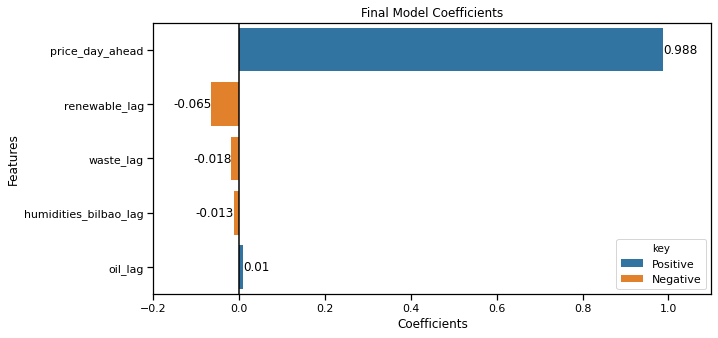

In [111]:
# Create results dataframe for display
df_results = pd.DataFrame({'Coefficients':lasso1.coef_}, index=X_train[cols].columns)
df_results['key'] = df_results.Coefficients.apply(lambda x: 'Negative' if x < 0 else 'Positive')
df_results.Coefficients = df_results.Coefficients.apply(lambda x: round(x,3))
df_results['magnitude'] = df_results.Coefficients.apply(lambda x: abs(x))
df_results.sort_values(by='magnitude', ascending=False, inplace=True)


sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(10,5))
fig
ax.set_xlim(-.2,1.1)
sns.barplot(
    y=df_results.index,
    x=df_results.Coefficients,
    data=df_results,
    hue='key',
    dodge=False,
);
plt.xticks();
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);
plt.title('Final Model Coefficients');
plt.ylabel('Features');
plt.axvline(x = 0, color = 'black');

**Interpretation:**
In the above plot, it is no surprise that `price_day_ahead` dominates the model.  The other features nudge that final price up or down. The model says that as renewable generation (feature represents other renewable outside major solar and wind) and waste generation decrease, the final price increases.  As generation from oil increases, the price also increases.  Finally  as the humidity in Bilbao decreases the price tends to decrease.

Next I'll plot the final model predictions, the `price_day_ahead` and the actual price over a week.  In addition , I'll plot the final model's residual and the `price_day_ahead` residual over time.  This should give us a better sense for how well our model did compared to the benchmark.

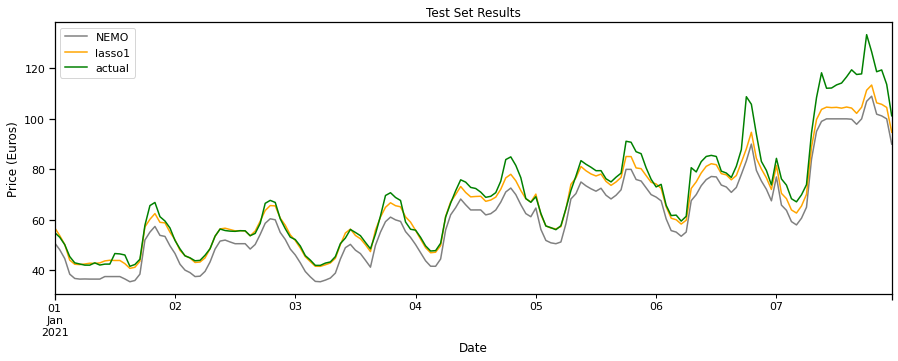

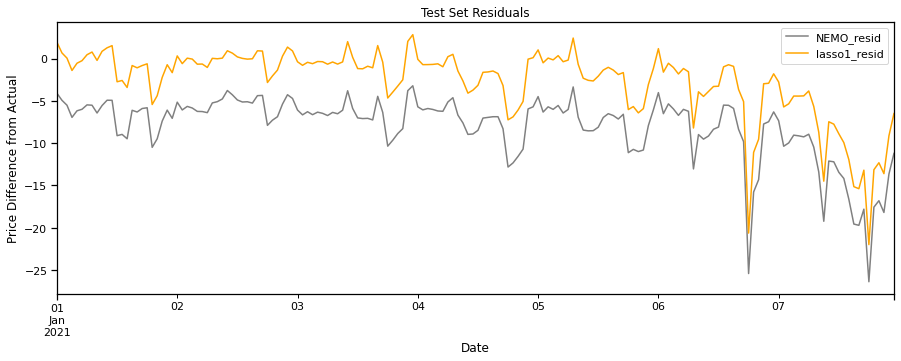

In [121]:
# Add model prediction, price_day_ahead, and actuals to dataframe
preds_final = lasso1.predict(X_test[cols])
predictions = pd.DataFrame({'lasso1':preds_final,
                           'NEMO':X_test.price_day_ahead,
                           'actual': y_test})

# Plot each over time
predictions.loc['2021-1-1': '2021-1-7', ['NEMO', 'lasso1', 'actual']].plot(figsize=(15,5), color=['gray', 'orange', 'g']);
plt.xlabel('Date');
plt.ylabel('Price (Euros)');
plt.title('Test Set Results');

# Get residuals
predictions['NEMO_resid'] = predictions.NEMO - predictions.actual
predictions['lasso1_resid'] = predictions.lasso1 - predictions.actual

#Plot
predictions.loc['2021-1-1':'2021-1-7', ['NEMO_resid', 'lasso1_resid']].plot(figsize=(15,5), color=['gray', 'orange']);
plt.xlabel('Date');
plt.ylabel('Price Difference from Actual');
plt.title('Test Set Residuals');

### Conclusion
___
This project set out to see if the price was predictable from generation, transmission, weather, and price day-ahead data. In the end, the price day-ahead was a strong predictor of tomorrow's price, dominating the model. However, there are other features that nudge the price either up or down. On days when renewable generation, waste generation, and the humidity in Bilbao are up the final price tends to be cheaper.  On days when energy generation from oil is up, the final price tends to be more expensive.

The other components of final price were modeled but only three could be easily predicted with the data.  These components are `price_capacity_payment`, `price_PBF_tech`, and `price_sec_reserve`.

On the whole, most of the generation weather, and transmission variables were not helpful in predicting the final energy price.

### Next Steps
___
Since most of the data in this project is very noisy, it would be beneficial to sit down with an expert who understands the calculation of `price_day_ahead`. Using some of the features that the NEMOs use to come up with this price would be useful in machine learning models. 

In combination with the appropriate data a GRU neural network ensemble, and convolutional neural network (CNNs) ensemble.  GRU NNs are similar to LSTM network, but more computationally more efficient. CNN are typically used for image classification but could be adapted for multi-step price forecasting.